In [1]:
import numpy as np 

import matplotlib.pyplot as plt 
import datetime as dt
from datetime import timedelta as td

%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 16]

In [2]:
usinggpu=True

if usinggpu:
    import cudf as pd
else:
    import pandas as pd

In [3]:
# To know the memory usage, just in case out of memory
import os, psutil

def memory_usage():
     process = psutil.Process(os.getpid())
     return process.memory_info()[0] / float(2 ** 20)

memory_usage() # initial memory usage

395.203125

# The workflow: Indicator, Signal and strategy

## The column name protocols between different stages and staff
So that the data source can be interpreted by strategy

In [4]:
def ma_col_name(nperiods):
    return "MA"+str(nperiods)

def pre_ma_col_name(nperiods):
    return "Pre_"+ma_col_name(nperiods)

def crossup_col_name(ma_short, ma_long):
    return str(ma_short)+"_CU_"+str(ma_long)

def crossdown_col_name(ma_short, ma_long):
    return str(ma_short)+"_CD_"+str(ma_long)

## The MA parameters we will use

In [5]:
ma_range_short=list(range(5,10+1))
ma_range_long=list(range(25,35+1))
ma_range=ma_range_short+ma_range_long
ma_range

[5, 6, 7, 8, 9, 10, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

## The Stoploss level we will use

In [6]:
stoploss_range=[x/100.0 for x in range(1,5+1)]
stoploss_range=[0.005]+stoploss_range+[1]
stoploss_range

[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 1]

# Backtesting

# To Load Market Data Indicators and Signals
So that the step 1, 2 are independent to back testing

In [7]:
# There are a big difference in read_csv between pandas and CuDF. So we similify the process to load as pandas at first
if usinggpu:
    import pandas
    df_pandas=pandas.read_csv("signals.csv" ,parse_dates=["datetime"],index_col="datetime")
    df_pandas.sort_index(ascending=True,inplace=True)
    
    df=pd.from_pandas(df_pandas)
else:
    df=pd.read_csv("signals.csv" ,parse_dates=["datetime"],index_col="datetime")
    df.sort_index(ascending=True,inplace=True)
# Test df.iloc[0]

In [10]:
df.dtypes==df_pandas.dtypes

sym         True
close       True
volume      True
MA5         True
MA6         True
MA7         True
MA8         True
MA9         True
MA10        True
MA25        True
MA26        True
MA27        True
MA28        True
MA29        True
MA30        True
MA31        True
MA32        True
MA33        True
MA34        True
MA35        True
Pre_MA5     True
Pre_MA6     True
Pre_MA7     True
Pre_MA8     True
Pre_MA9     True
Pre_MA10    True
Pre_MA25    True
Pre_MA26    True
Pre_MA27    True
Pre_MA28    True
            ... 
9_CD_32     True
9_CU_32     True
9_CD_33     True
9_CU_33     True
9_CD_34     True
9_CU_34     True
9_CD_35     True
9_CU_35     True
10_CD_25    True
10_CU_25    True
10_CD_26    True
10_CU_26    True
10_CD_27    True
10_CU_27    True
10_CD_28    True
10_CU_28    True
10_CD_29    True
10_CU_29    True
10_CD_30    True
10_CU_30    True
10_CD_31    True
10_CU_31    True
10_CD_32    True
10_CU_32    True
10_CD_33    True
10_CU_33    True
10_CD_34    True
10_CU_34    Tr

In [12]:
df.dtypes

sym          object
close       float64
volume      float64
MA5         float64
MA6         float64
MA7         float64
MA8         float64
MA9         float64
MA10        float64
MA25        float64
MA26        float64
MA27        float64
MA28        float64
MA29        float64
MA30        float64
MA31        float64
MA32        float64
MA33        float64
MA34        float64
MA35        float64
Pre_MA5     float64
Pre_MA6     float64
Pre_MA7     float64
Pre_MA8     float64
Pre_MA9     float64
Pre_MA10    float64
Pre_MA25    float64
Pre_MA26    float64
Pre_MA27    float64
Pre_MA28    float64
             ...   
9_CD_32        bool
9_CU_32        bool
9_CD_33        bool
9_CU_33        bool
9_CD_34        bool
9_CU_34        bool
9_CD_35        bool
9_CU_35        bool
10_CD_25       bool
10_CU_25       bool
10_CD_26       bool
10_CU_26       bool
10_CD_27       bool
10_CU_27       bool
10_CD_28       bool
10_CU_28       bool
10_CD_29       bool
10_CU_29       bool
10_CD_30       bool


In [13]:
count=0
for close_p, ma_5_p in zip(df["close"],df["MA5"]):
    #print(close_p, ma_5_p)
    count+=1
print(count)
        

14125


## Backtesting

In [59]:
def strategy_test(df, ma_short=5, ma_long=25, stoploss_rate=0.05):
    """Backtest for a set of (MA short periods, MA long periods, stop loss rate)"""
    ticker_holdings = []  #Holding of ticks
    ticker_trades=[]
    ticker_stoploss=[]
    trades_pl=[]
    #stoplosses_pl=[]
    cash_flows=[]  #Cash flow (In when sell and out when buy)
    
    cum_cash_flows=[] # In order to avoid cumsum(), which is not supported by CUDF
    
    current_holding=0.0
    previous_cost_Buys=0.0
    previous_cost_Sells=0.0
    initial_cash=0.0  # The first investment as cash 
    
    cum_cash_flow=0.0
    
    crossdown=crossdown_col_name(ma_short,ma_long)
    crossup=crossup_col_name(ma_short,ma_long)
    
    temp_count=0
    #for index_df, row in df.iterrows():
    for (closeprice,bool_crossdown, bool_crossup) in zip(df["close"],df[crossdown], df[crossup]):
        #closeprice=row["close"]
        #bool_crossdown=row[crossdown]
        #bool_crossup=row[crossup]
                
        net_cash_flow=0.0
        trades=0 #non-cover
        stoploss_trades=0 #cover
        trade_pl=0.0
        #stoploss_pl=0
        
        if stoploss_rate<1: # When stoploss>=1, which means no stoploss!
            # stop loss first
            if current_holding>0 and closeprice<((1-stoploss_rate)*previous_cost_Buys): # stop loss for long
                stoploss_trades=-current_holding
                current_holding=0.0
                net_cash_flow=(1-stoploss_rate)*previous_cost_Buys*abs(stoploss_trades)
                #stoploss_pl=-stoploss_rate # The loss
                trade_pl=-stoploss_rate # The loss
            elif current_holding<0 and closeprice>(1+stoploss_rate)*previous_cost_Sells: # stop loss for short
                stoploss_trades=-current_holding
                current_holding=0.0
                #stoploss_pl=-stoploss_rate
                trade_pl=-stoploss_rate # The loss
                net_cash_flow=-(1+stoploss_rate)*previous_cost_Sells*abs(stoploss_trades)
        
        
        # Then we deal with buy and sell signal
        if bool_crossup:
            if (current_holding<0): # cover short
                trade_pl=-(closeprice/previous_cost_Sells-1)
            
            current_holding=current_holding+1.0
            
            if current_holding>1:
                print(temp_count, bool_crossup)
                
            net_cash_flow=net_cash_flow-closeprice
            previous_cost_Buys=closeprice
            trades=1.0
            
            
            if initial_cash<1:
                initial_cash=closeprice
                
        elif bool_crossdown:
            if (current_holding>0): # cover long
                trade_pl=closeprice/previous_cost_Buys-1
            
            current_holding=current_holding-1.0
            net_cash_flow=net_cash_flow+closeprice
            previous_cost_Sells=closeprice
            trades=-1.0
            
            if initial_cash<1:
                initial_cash=closeprice
                  
        ticker_holdings.append(current_holding)

        cash_flows.append(net_cash_flow)
        cum_cash_flow+=net_cash_flow
        cum_cash_flows.append(cum_cash_flow)
        ticker_trades.append(trades)
        ticker_stoploss.append(stoploss_trades)
        trades_pl.append(trade_pl)
        #stoplosses_pl.append(stoploss_pl)
        
    df_strategy=pd.DataFrame({"close":df["close"],"holding": ticker_holdings,"cash_flows":cash_flows, \
                          "trades":ticker_trades,"stoploss":ticker_stoploss, "trades_pl":trades_pl\
                              #,"stoplosses_pl":stoplosses_pl
                              ,"cum_cash_flow":cum_cash_flows
                             },index=df.index)
    
    #df_strategy["cum_cash_flow"]=df_strategy["cash_flows"].cumsum() # CUDF doesn't support CUMSUM
    df_strategy["cash"]=pd.Series([initial_cash+cum_cf for cum_cf in df_strategy["cum_cash_flow"]],index=df.index).astype("float64")
    #print(df_strategy.dtypes)
    stra=df_strategy["holding"].astype("float64")*df_strategy["close"]+df_strategy["cash"]
    df_strategy.add_column("strategy",stra, forceindex=True)
    df_strategy.add_column("strategy_pl_cum",df_strategy["strategy"]/initial_cash-1, forceindex=True)
    
    return df_strategy

In [38]:
df_strategy.dtypes

close            float64
holding          float64
cash_flows       float64
trades           float64
stoploss           int64
trades_pl        float64
cum_cash_flow    float64
cash             float64
strategy         float64
dtype: object

In [41]:
print(df_strategy.dtypes)
    #df_strategy["holding"]=df_strategy["holding"].astype("int32")
    #print(df_strategy.dtypes)
holding = df_strategy['holding']
close = df_strategy['close']
cash = df_strategy['cash']

def kernel(holding, close, cash, stv):
     for i, (x, y, z) in enumerate(zip(holding, close, cash)):
         stv[i] =x*y+z
         
df_strategy.apply_rows(kernel,
               incols=['holding', 'close', 'cash'],
               outcols=dict(stv=np.float64),
                      kwargs=dict())

print(df_strategy.dtypes)

close            float64
holding          float64
cash_flows       float64
trades           float64
stoploss           int64
trades_pl        float64
cum_cash_flow    float64
cash             float64
strategy         float64
dtype: object


GDFError: GDF_UNSUPPORTED_DTYPE

## We define the metrics 

In [42]:
# global parameters we share between 
annual_trading_days=252

risk_free=0.01 # for 2018 the low interest rate
risk_free_5m=(1+risk_free)**(1/(annual_trading_days*12*24))-1 
annualized_parameter=annual_trading_days**0.5

target_daily_return=0 # We use 0 as the target daily return

In [43]:
risk_free_5m

1.371022313456649e-07

### Sharpe Ratio

In [44]:
def sharpe_ratio(values):
    """To calculate Sharpe Ratio by portfolio values"""
    daily_return=values.pct_change()
    sharpe_ratio=(daily_return.mean()-risk_free_5m)/daily_return.std()
    sharpe_ratio_annual=annualized_parameter*sharpe_ratio
    return sharpe_ratio,sharpe_ratio_annual

### Sortino Ratio

In [45]:
def sortino_ratio(values,target_return=0):
    """To calculate Sortino Ratio by portfolio values"""    
    daily_return=values.pct_change()
    expected_return = daily_return.mean()

    df_temp=daily_return.to_frame("daily")
    sq_mean=df_temp.applymap(lambda x: (x-target_return)**2 if x<target_return else 0).mean()[0] 
    
    #print(sq_mean)
    down_stdev = np.sqrt(sq_mean)
    
    sortino_ratio = (expected_return - risk_free_5m)/down_stdev
    
    sortino_ratio_annual=annualized_parameter*sortino_ratio
    
    return sortino_ratio, sortino_ratio_annual

### Maximum Drawdown

In [46]:
def max_drawdown(values):
    """To calculate maximum drawdown"""
    return 1-min(values/values.cummax()) # We use positive value

In [58]:
if usinggpu:
    def strategy_metrics(value_serie):
        return 0,0,0    
else:
    def strategy_metrics(value_serie):
        """To calculate all required performance indicators"""
        sharpe,sharpe_annual=sharpe_ratio(value_serie)
        sortino, sortino_annual=sortino_ratio(value_serie)
        max_dd=max_drawdown(value_serie)
        return sharpe, sortino,max_dd

In [48]:
# clear global variables
df_metrics=pd.DataFrame()
series=[]
dfs={}

In [68]:
def all_strategy_test(ma_range_short,ma_range_long,stoploss_range):
    """Backtest parameter combinations of MA short range, MA long range and stop loss range."""
    global df_metrics,series,dfs
    df_metrics=pd.DataFrame()
    series=[]
    dfs={}
    
    for ma_short in ma_range_short:
        for ma_long in ma_range_long:
            for stoploss in stoploss_range:
                strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                df_strategy=strategy_test(df, ma_short, ma_long, stoploss)
                dfs[strategy_name]=df_strategy
                
                sharpe_ratio, sortino,max_dd=strategy_metrics(df_strategy.strategy)
            
                trades_total=abs(sum(df_strategy.trades))+abs(sum(df_strategy.stoploss))
                trades_mean=df_strategy.trades_pl.mean()
                final_pl=df_strategy.strategy_pl_cum.iloc[-1]
                    
                series.append(pd.Series({"strategy_name":strategy_name,"ma_short":ma_short,"ma_long":ma_long,\
                                                        "stoploss": stoploss,"sharpe_ratio":sharpe_ratio,"sortino_ratio":sortino,\
                                                        "max_drawdown":max_dd,\
                                        "Final_Return":final_pl,"Total_Trades":trades_total,"Average_Trades_PL":trades_mean\
                                        }))               
    
    df_metrics=pd.concat(series,ignore_index=True,axis=1)
    
    if not usinggpu:
        df_metrics.transpose()
        df_metrics.set_index('strategy_name', inplace=True)
        df_metrics.ma_short=df_metrics.ma_short.astype("int64")
        df_metrics.ma_long=df_metrics.ma_long.astype("int64")
        df_metrics.stoploss=df_metrics.stoploss.astype("float64")
        df_metrics.sharpe_ratio =df_metrics.sharpe_ratio.astype("float64")
        df_metrics.sortino_ratio =df_metrics.sortino_ratio.astype("float64")
        df_metrics.max_drawdown=df_metrics.max_drawdown.astype("float64")
        df_metrics.Final_Return=df_metrics.Final_Return.astype("float64")
        df_metrics.max_drawdown=df_metrics.max_drawdown.astype("float64")
        df_metrics.Total_Trades=df_metrics.Total_Trades.astype("int64")
        df_metrics.Average_Trades_PL=df_metrics.Average_Trades_PL.astype("float64")

## To Back Test All Strategy Combinations (about 6 minutes)

In [74]:
dt_start=dt.datetime.now()
all_strategy_test(ma_range_short,ma_range_long,stoploss_range) 
#all_strategy_test([7],[35],stoploss_range) 
dt_end=dt.datetime.now()
print(dt_end-dt_start)
df_metrics.head()

0:42:26.020105


<cudf.DataFrame ncols=462 nrows=5 >

In [75]:
print(df_metrics)

                   -1                  0                  1                  2                  3                  4                  5 ...                460
0      strategy_name      strategy_name      strategy_name      strategy_name      strategy_name      strategy_name      strategy_name ...      strategy_name
1           ma_short           ma_short           ma_short           ma_short           ma_short           ma_short           ma_short ...           ma_short
2            ma_long            ma_long            ma_long            ma_long            ma_long            ma_long            ma_long ...            ma_long
3           stoploss           stoploss           stoploss           stoploss           stoploss           stoploss           stoploss ...           stoploss
4       sharpe_ratio       sharpe_ratio       sharpe_ratio       sharpe_ratio       sharpe_ratio       sharpe_ratio       sharpe_ratio ...       sharpe_ratio
5      sortino_ratio      sortino_ratio      sortin

# Report Generation

In [34]:
# To chart the results
def chart_strategy_results(ma_range_short,ma_range_long,stoploss_range, indetail=False):
    global df_metrics,series,dfs
    
    nosubplot=len(ma_range_short)+len(ma_range_long)<=2
    
    if nosubplot:
        fig,axes=plt.subplots()
    else:
        fig,axes = plt.subplots(len(ma_range_short), len(ma_range_long), sharex='col', sharey='row')
    
    for ma_short in ma_range_short:
        for ma_long in ma_range_long:
            #print(ma_range_short.index(ma_short),ma_range_long.index(ma_long))
            
            if nosubplot:
                ax=axes
            else: 
                ax=axes[ma_range_short.index(ma_short),ma_range_long.index(ma_long)]
            
            ax.text(0.5, 0.5, str(ma_short)+"  "+str(ma_long), color='red', ha='center',transform=ax.transAxes)
                    #ax.set_title(str(ma_short)+"  "+str(ma_long))
            #ax.set_title("{:.2f}".format(sharpe_ratio)+",{:.2f}".format(sortino)+",{:.2f}".format(max_dd))
                    
            for stoploss in stoploss_range:
                # To fetch data
                strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                
                try:
                    df_strategy=dfs[strategy_name]
                
                    sharpe, sortino,max_dd,final_pl,trades_total,trades_mean\
                        =df_metrics.loc[strategy_name,["sharpe_ratio","sortino_ratio","max_drawdown",\
                                        "Final_Return","Total_Trades","Average_Trades_PL"]]
                except KeyError:
                    continue
                    
                # To chart
                #df_strategy.strategy_pl_cum.plot(ax=ax,label="{:.0%}".format(stoploss))
                if stoploss<1:
                    ax.plot(df_strategy.index, df_strategy.strategy_pl_cum, label="{:.1%}".format(stoploss))
                else:
                    ax.plot(df_strategy.index, df_strategy.strategy_pl_cum, label="No Stop Loss")
            
            if indetail:
                ax.legend(loc='lower left', shadow=True)

    plt.show()    


/home/ying/.conda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


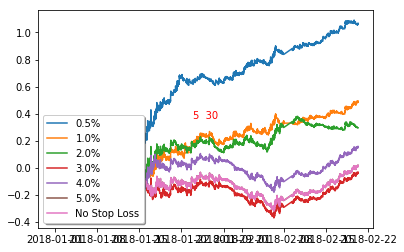

In [35]:
chart_strategy_results([5],[30],stoploss_range,True) # Test

In [36]:
df_metrics[(df_metrics.ma_short==5) & (df_metrics.ma_long==30)]

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_30_0.005,5,30,0.005,0.021422,0.031880,0.118090,1.061817,947,0.000097
5_30_0.01,5,30,0.010,0.010553,0.015231,0.221069,0.487084,815,0.000050
5_30_0.02,5,30,0.020,0.007305,0.010504,0.210301,0.295138,714,0.000035
5_30_0.03,5,30,0.030,0.000970,0.001395,0.432688,-0.038262,693,0.000005
5_30_0.04,5,30,0.040,0.004629,0.006695,0.261801,0.151366,689,0.000019
5_30_0.05,5,30,0.050,0.001900,0.002759,0.387121,0.012302,687,0.000009
5_30_1,5,30,1.000,0.001900,0.002759,0.387121,0.012302,687,0.000009


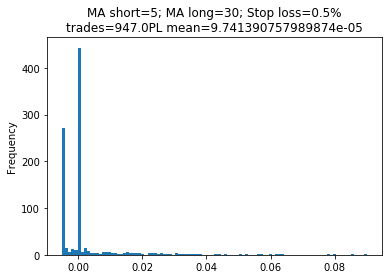

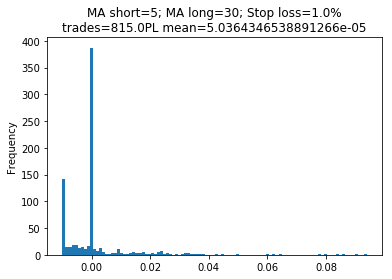

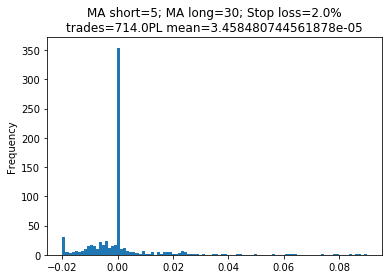

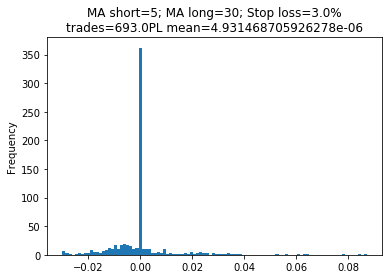

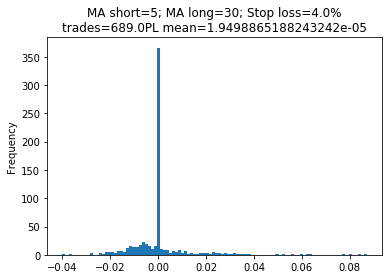

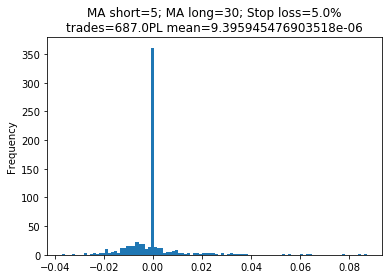

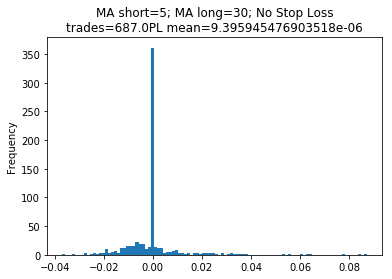

In [37]:
def chart_trade_pl(ma_short, ma_long, stoploss_range):
    for stoploss in stoploss_range:
        # To fetch data
        strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                
        try:
            df_strategy=dfs[strategy_name]
                
            sharpe, sortino,max_dd,final_pl,trades_total,trades_mean\
                        =df_metrics.loc[strategy_name,["sharpe_ratio","sortino_ratio","max_drawdown",\
                                        "Final_Return","Total_Trades","Average_Trades_PL"]]
        except KeyError:
            continue
        
        df_filter=abs(df_strategy["trades"])+abs(df_strategy["stoploss"])>0
        
        df_strategy[df_filter].trades_pl.plot(kind="hist",bins=100);
            
        if stoploss<1:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; Stop loss={:.1%}".format(stoploss)+\
                          "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))
        else:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; No Stop Loss"+\
                      "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))

        plt.show()

chart_trade_pl(5,30,stoploss_range)            

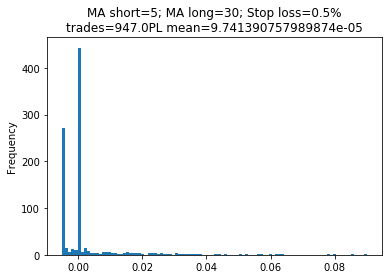

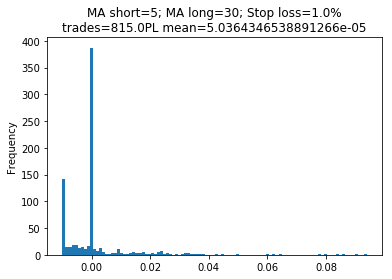

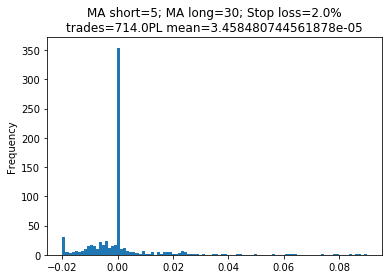

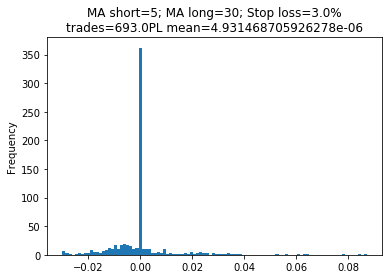

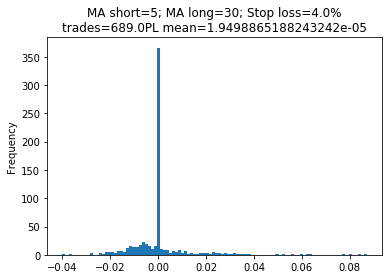

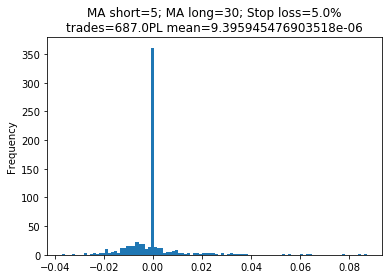

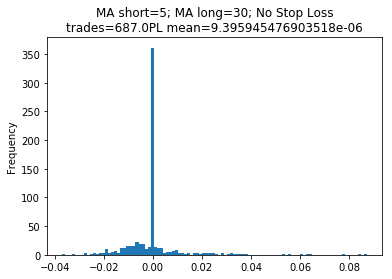

In [38]:
def chart_heatmap(ma_short, ma_long, stoploss_range):
    for stoploss in stoploss_range:
        # To fetch data
        strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                
        try:
            df_strategy=dfs[strategy_name]
                
            sharpe, sortino,max_dd,final_pl,trades_total,trades_mean\
                        =df_metrics.loc[strategy_name,["sharpe_ratio","sortino_ratio","max_drawdown",\
                                        "Final_Return","Total_Trades","Average_Trades_PL"]]
        except KeyError:
            continue
        
        df_filter=abs(df_strategy["trades"])+abs(df_strategy["stoploss"])>0
        
        df_strategy[df_filter].trades_pl.plot(kind="hist",bins=100);
            
        if stoploss<1:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; Stop loss={:.1%}".format(stoploss)+\
                          "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))
        else:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; No Stop Loss"+\
                      "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))

        plt.show()

chart_heatmap(5,30,stoploss_range)            

In [39]:
df_metrics.head()

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_25_0.005,5,25,0.005,0.022801,0.033931,0.091947,1.046471,1065,0.000088
5_25_0.01,5,25,0.010,0.012218,0.017792,0.160273,0.551697,905,0.000049
5_25_0.02,5,25,0.020,0.010294,0.014847,0.192186,0.444551,791,0.000044
5_25_0.03,5,25,0.030,0.002494,0.003512,0.279271,0.043530,776,0.000007
5_25_0.04,5,25,0.040,0.006253,0.009065,0.236733,0.231064,769,0.000024


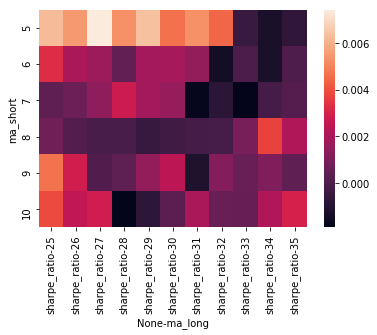

In [41]:
import seaborn as sns
table_sharpe = pd.pivot_table(df_metrics, values=['sharpe_ratio'], index=['ma_short'],columns=['ma_long'],
                     aggfunc={'sharpe_ratio': np.median})
sns.heatmap(table_sharpe)

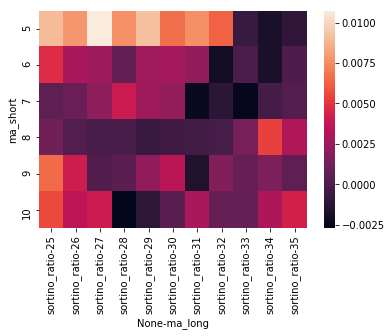

In [42]:
table_sortino = pd.pivot_table(df_metrics, values=['sortino_ratio'], index=['ma_short'],columns=['ma_long'],
                     aggfunc={'sortino_ratio': np.median})
sns.heatmap(table_sortino)

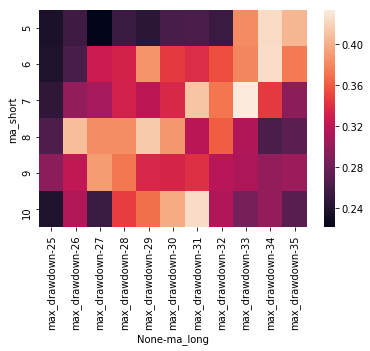

In [43]:
table_max_drawdown = pd.pivot_table(df_metrics, values=['max_drawdown'], index=['ma_short'],columns=['ma_long'],
                     aggfunc={'max_drawdown': np.median})
sns.heatmap(table_max_drawdown)

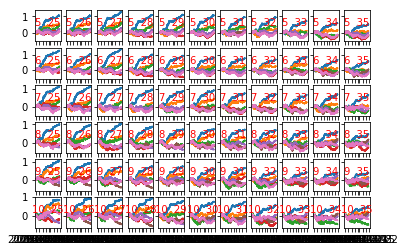

In [44]:
chart_strategy_results(ma_range_short,ma_range_long,stoploss_range) 

### To save the metrics data

In [45]:
df_metrics.to_csv("metrics.csv")

## Interactive Analysis on the metrics

In [46]:
df_metrics.sort_values("Average_Trades_PL",ascending=False).head()

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
6_27_0.005,6,27,0.005,0.026146,0.039174,0.096158,1.349295,967,0.000117
5_27_0.005,5,27,0.005,0.026080,0.038846,0.081306,1.256488,991,0.000109
6_25_0.005,6,25,0.005,0.026229,0.039440,0.094679,1.243817,1011,0.000105
7_26_0.005,7,26,0.005,0.023255,0.034565,0.114354,1.149478,937,0.000104
5_29_0.005,5,29,0.005,0.022271,0.033172,0.095447,1.098400,967,0.000099


In [47]:
df_metrics.sort_values("Final_Return",ascending=False).head(10)

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
6_27_0.005,6,27,0.005,0.026146,0.039174,0.096158,1.349295,967,0.000117
5_27_0.005,5,27,0.005,0.026080,0.038846,0.081306,1.256488,991,0.000109
6_25_0.005,6,25,0.005,0.026229,0.039440,0.094679,1.243817,1011,0.000105
7_26_0.005,7,26,0.005,0.023255,0.034565,0.114354,1.149478,937,0.000104
7_25_0.005,7,25,0.005,0.024448,0.036544,0.109883,1.135106,951,0.000099
5_29_0.005,5,29,0.005,0.022271,0.033172,0.095447,1.098400,967,0.000099
5_28_0.005,5,28,0.005,0.022360,0.033262,0.092306,1.083445,991,0.000098
7_27_0.005,7,27,0.005,0.022665,0.033780,0.108497,1.079105,895,0.000099
5_30_0.005,5,30,0.005,0.021422,0.031880,0.118090,1.061817,947,0.000097


In [48]:
df_by_sharpe=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("sharpe_ratio",ascending=False).head(10)
df_by_sharpe

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03      0.007407       0.010744      0.220947   
         29           0.03      0.006369       0.009229      0.245154   
         25           0.03      0.006253       0.009065      0.236733   
         26           0.03      0.005467       0.007861      0.256381   
         28           0.03      0.005293       0.007665      0.253864   
         31           0.03      0.005272       0.007613      0.263142   
9        25           0.03      0.004686       0.006590      0.296020   
5        30           0.03      0.004629       0.006695      0.261801   
         32           0.03      0.004403       0.006316      0.253770   
10       25           0.03      0.003918       0.005624      0.238225   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         29           0.241214           706           0.000027  
         25           0.231064           776           0.000024  
         26           0.187115           756           0.000020  
         28           0.185019           726           0.000022  
         31           0.184634           673           0.000022  
9        25           0.149457           663           0.000016  
5        30           0.151366           693           0.000019  
         32           0.137412           663           0.000016  
10       25           0.114713           653           0.000008

In [49]:
df_by_sortino=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("sortino_ratio",ascending=False).head(10)
df_by_sortino

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03      0.007407       0.010744      0.220947   
         29           0.03      0.006369       0.009229      0.245154   
         25           0.03      0.006253       0.009065      0.236733   
         26           0.03      0.005467       0.007861      0.256381   
         28           0.03      0.005293       0.007665      0.253864   
         31           0.03      0.005272       0.007613      0.263142   
         30           0.03      0.004629       0.006695      0.261801   
9        25           0.03      0.004686       0.006590      0.296020   
5        32           0.03      0.004403       0.006316      0.253770   
10       25           0.03      0.003918       0.005624      0.238225   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         29           0.241214           706           0.000027  
         25           0.231064           776           0.000024  
         26           0.187115           756           0.000020  
         28           0.185019           726           0.000022  
         31           0.184634           673           0.000022  
         30           0.151366           693           0.000019  
9        25           0.149457           663           0.000016  
5        32           0.137412           663           0.000016  
10       25           0.114713           653           0.000008

In [50]:
df_by_maxdd=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("max_drawdown").head(10)
df_by_maxdd

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03      0.007407       0.010744      0.220947   
         25           0.03      0.006253       0.009065      0.236733   
6        25           0.03      0.003298       0.004795      0.237926   
10       25           0.03      0.003918       0.005624      0.238225   
5        29           0.03      0.006369       0.009229      0.245154   
7        25           0.03      0.000407       0.000584      0.247894   
10       27           0.03      0.002849       0.004050      0.253531   
5        32           0.03      0.004403       0.006316      0.253770   
         28           0.03      0.005293       0.007665      0.253864   
         26           0.03      0.005467       0.007861      0.256381   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         25           0.231064           776           0.000024  
6        25           0.081803           744           0.000013  
10       25           0.114713           653           0.000008  
5        29           0.241214           706           0.000027  
7        25          -0.050362           694           0.000003  
10       27           0.055713           619           0.000017  
5        32           0.137412           663           0.000016  
         28           0.185019           726           0.000022  
         26           0.187115           756           0.000020

In [51]:
selected_set=set(df_by_sharpe.index) & set(df_by_sortino.index) & set(df_by_maxdd.index)
selected_set

{(5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 32), (10, 25)}

In [52]:
df_metrics[(df_metrics.ma_short==5) & ((df_metrics.ma_long<=28) & (df_metrics.ma_long>=25))].sort_values(["Average_Trades_PL"], ascending=False)

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_27_0.005,5,27,0.005,0.026080,0.038846,0.081306,1.256488,991,0.000109
5_28_0.005,5,28,0.005,0.022360,0.033262,0.092306,1.083445,991,0.000098
5_26_0.005,5,26,0.005,0.022138,0.032912,0.097288,1.040913,1031,0.000089
5_25_0.005,5,25,0.005,0.022801,0.033931,0.091947,1.046471,1065,0.000088
5_27_0.01,5,27,0.010,0.013192,0.019128,0.162186,0.660277,863,0.000065
5_27_0.02,5,27,0.020,0.012264,0.017794,0.214238,0.581388,755,0.000060
5_26_0.01,5,26,0.010,0.012121,0.017559,0.207840,0.604924,885,0.000057
5_28_0.02,5,28,0.020,0.010647,0.015361,0.207225,0.502199,739,0.000056
5_25_0.01,5,25,0.010,0.012218,0.017792,0.160273,0.551697,905,0.000049


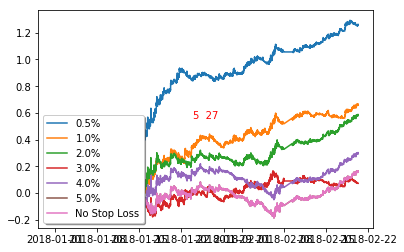

In [53]:
#all_strategy_test([5],[27],[0.005,0.01,0.02,0.03,0.04,0.05],True) # To add more tests for the optimized set
chart_strategy_results([5],[27],stoploss_range,True) # Test

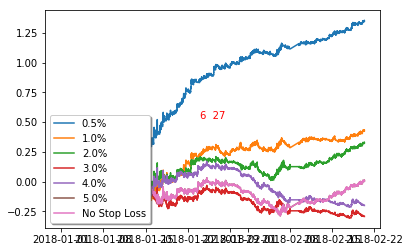

In [54]:
chart_strategy_results([6],[27],stoploss_range,True) # Test

## Finally, we choose (5,27,0.5%) as the optimized set.